In [3]:
# Run this cell first
import os
import cv2
import json
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from dotenv import load_dotenv
from tqdm import tqdm
from scoring.vlm_eval import bb_iou

load_dotenv()
TEAM_NAME, TEAM_TRACK = os.getenv("TEAM_NAME"), os.getenv("TEAM_TRACK")
on_gcp = None not in [TEAM_NAME, TEAM_TRACK]

track_dataset_dir = Path(f"{'/home/jupyter/' if on_gcp else ''}advanced")
truth_jsonl_file = track_dataset_dir / "vlm.jsonl"

from ultralytics import YOLO
# YOLO_MODEL_NAME = "yolov8m.pt"
YOLO_MODEL_NAME = "vlm/models/yolov8m-v1-300/weights/best.pt"
yolo_model = YOLO(YOLO_MODEL_NAME)
class_id_to_name = yolo_model.names # See datasets/yolov8/data.yaml for the full class mapping

In [12]:
def read_jsonl(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            yield json.loads(line)

def extract_categories(data):
    categories = {}
    for item in data:
        for annotation in item['annotations']:
            caption = annotation['caption']
            if caption not in categories:
                categories[caption] = True
    return list(categories.keys())

def create_category_mapping(categories):
    return {category: idx for idx, category in enumerate(categories)}

def get_category_id(caption, category_mapping):
    for category in category_mapping:
        if category in caption:
            return category_mapping[category]
    return -1

categories = extract_categories(read_jsonl(truth_jsonl_file))
label2id = create_category_mapping(categories)
id2label = {value: key for key, value in label2id.items()}
print(label2id)

{'grey missile': 0, 'red, white, and blue light aircraft': 1, 'green and black missile': 2, 'white and red helicopter': 3, 'grey camouflage fighter jet': 4, 'grey and white fighter plane': 5, 'white and black drone': 6, 'white and black fighter jet': 7, 'white missile': 8, 'black and white commercial aircraft': 9, 'grey drone': 10, 'yellow, red, and grey helicopter': 11, 'yellow commercial aircraft': 12, 'black cargo aircraft': 13, 'yellow helicopter': 14, 'white and black light aircraft': 15, 'grey and black fighter plane': 16, 'red fighter plane': 17, 'blue helicopter': 18, 'white, red, and green fighter plane': 19, 'black camouflage fighter jet': 20, 'green light aircraft': 21, 'blue and yellow fighter jet': 22, 'white fighter jet': 23, 'red fighter jet': 24, 'blue and white light aircraft': 25, 'white and black helicopter': 26, 'white and blue fighter plane': 27, 'grey commercial aircraft': 28, 'blue and grey fighter jet': 29, 'green and brown camouflage fighter jet': 30, 'red and 

In [39]:
colours = [(0, 204, 0), (255, 0, 255), (0, 127, 255)]

def display_image(img_path, annotations, title=None, truth_bbox=None, predict_idx=None, colours=colours, show=True):
    # annotations should be a list of dict { 'bbox': [l, t, w, h], 'caption': 'something' }
    image = cv2.imread(img_path)
    if title is not None:
        cv2.putText(image, title, (6, 32), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cap_n = min(len(colours), len(annotations))
    for i, annotation in enumerate(annotations):
        l, t, w, h = annotation["bbox"]
        colour = colours[i % cap_n]
        if "caption" in annotation and i != predict_idx:
            cv2.putText(image, annotation["caption"], (l, max(0, t-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, colour, 2)
        elif "class" in annotation:
            cv2.putText(image, annotation["class"], (l, max(0, t+h+16)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, colour, 2)
        if i == predict_idx:
            cv2.putText(image, "Predicted", (l, max(0, t-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            colour = (0, 0, 255)
        cv2.rectangle(image, (l, t), (l+w, t+h), colour, 2)
    if isinstance(truth_bbox, list):
        t_l, t_t, t_w, t_h = truth_bbox
        cv2.rectangle(image, (t_l, t_t), (t_l+t_w, t_t+t_h), (255, 0, 0), 2)
        cv2.putText(image, "Truth", (t_l, max(0, t_t-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                
    image_out = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if show:
        display(Image.fromarray(image_out))
    return np.array(image_out)

def extract_object_class(caption, return_name=False):
    # Extract the object's class from the caption
    if "aircraft" in caption: # light, commercial, cargo
        class_id = 80
    elif "drone" in caption:
        class_id = 81
    elif "helicopter" in caption:
        class_id = 82
    elif "fighter plane" in caption:
        class_id = 83
    elif "fighter jet" in caption:
        class_id = 84
    elif "missile" in caption:
        class_id = 85
    else:
        print(f"Unknown class for caption: {caption}")
        return None
    return class_id_to_name[class_id] if return_name else class_id
    # class_id = label2id[caption]
    # return id2label[class_id] if return_name else class_id

### YOLOv8 Inference

The cell below does 3 things:  
1. Display the truth bounding box overlayed on the original image.
2. Displays all objects detected in the image using YOLOv8.
3. Displays the prediction based on the caption describing the object.

In [6]:
from transformers import CLIPProcessor, CLIPModel
MODEL = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained(MODEL).to(device)
clip_processor = CLIPProcessor.from_pretrained(MODEL)

/home/lunarbunny/til-24-siewsugar/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Image #3501, Caption: blue, yellow, and black helicopter


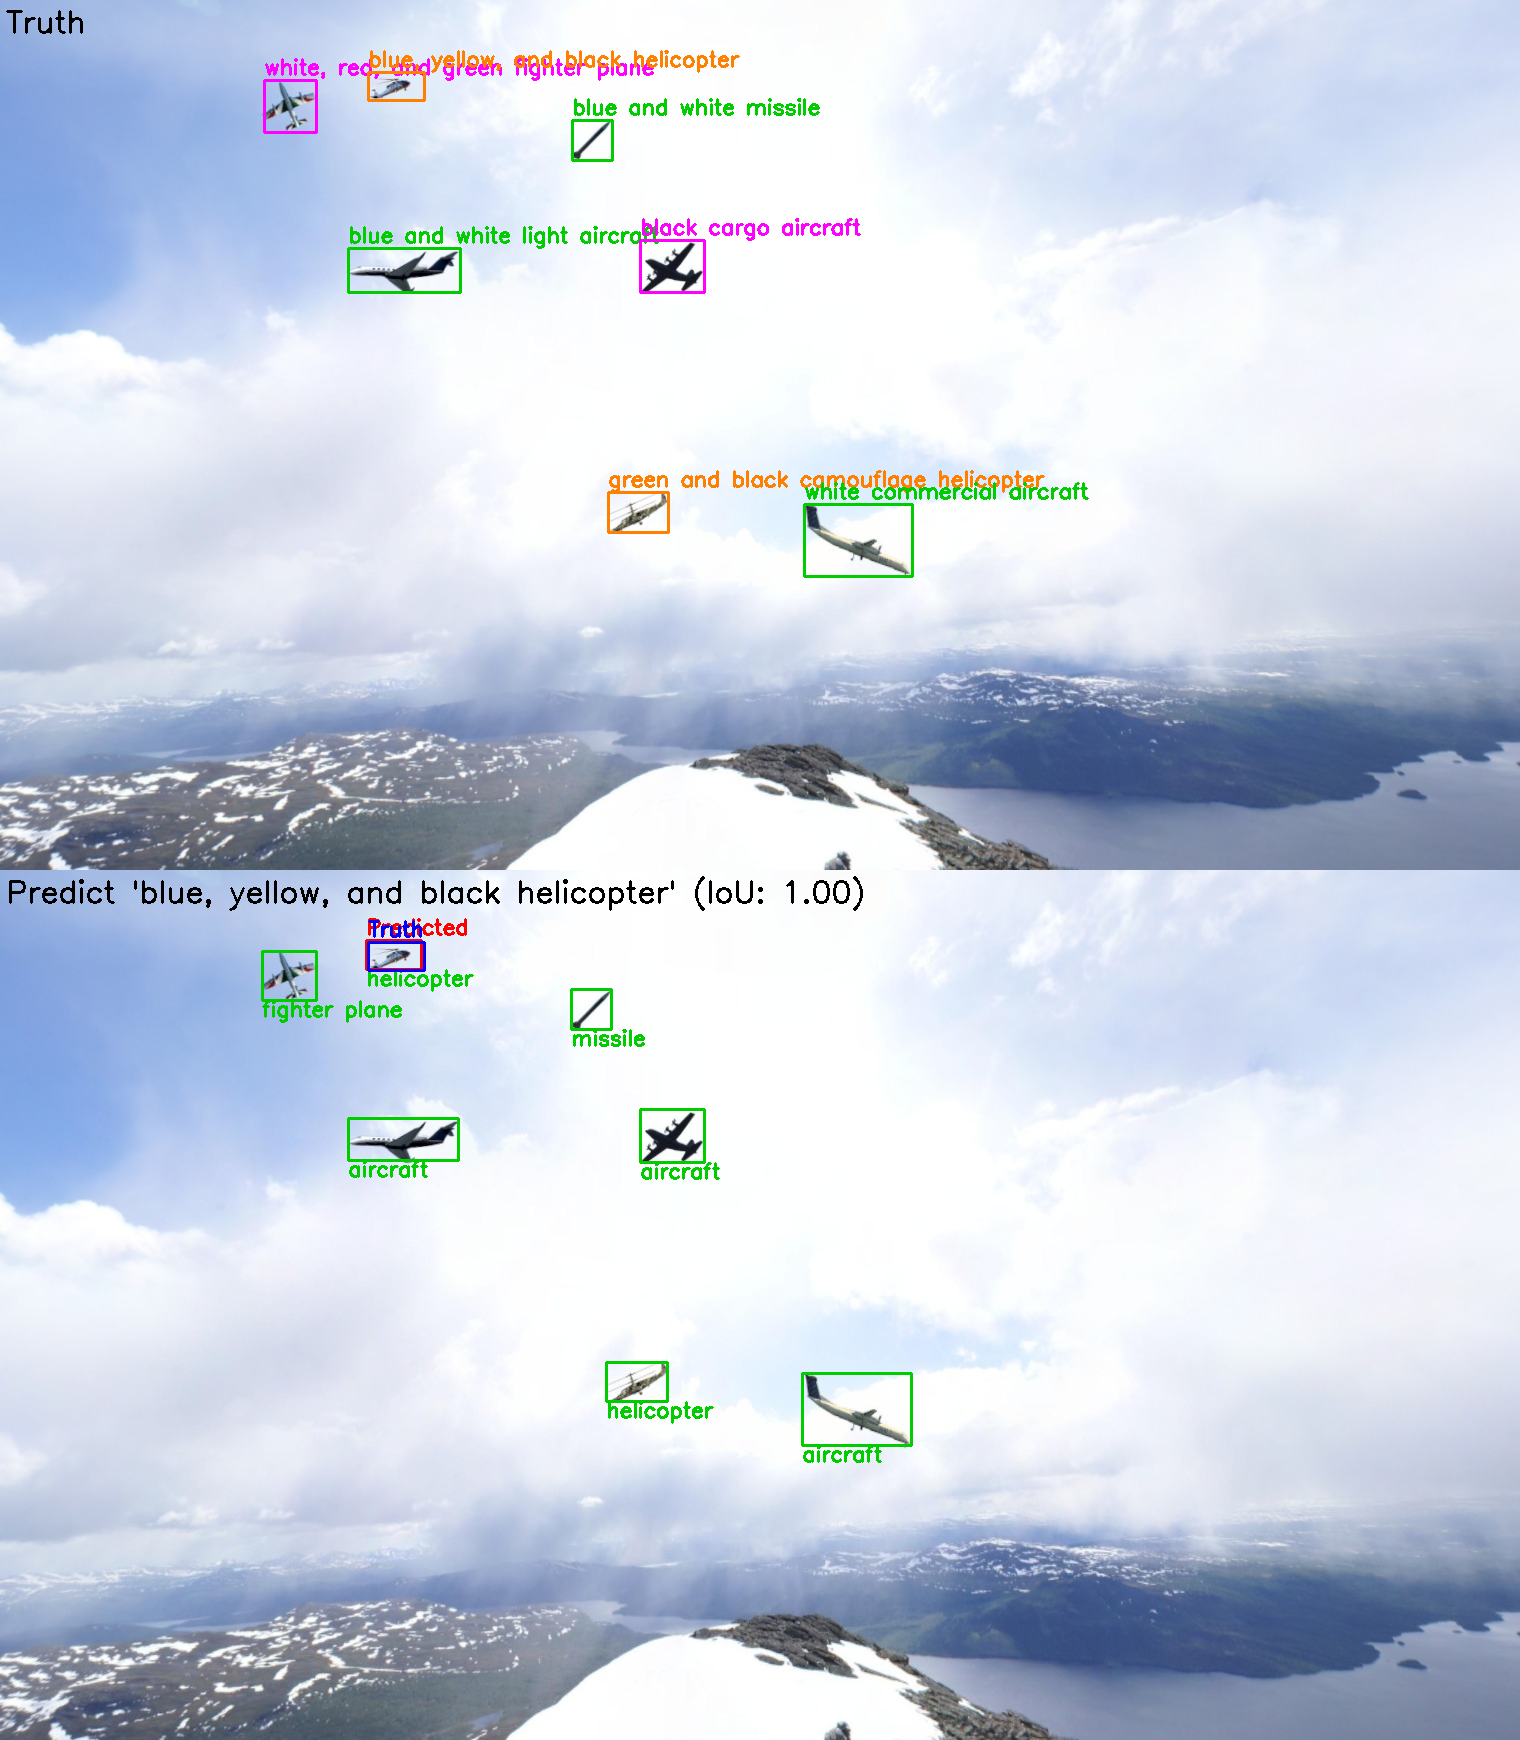

In [43]:
# Set image number and caption to predict here
image_no, caption_idx = 3501, 5

# Display truth bounding box for selected image based on vlm.jsonl
img_path = Path(f"{'/home/jupyter/' if on_gcp else ''}advanced/images/image_{image_no}.jpg")
caption = None
with open(truth_jsonl_file) as f:
    for i, line in enumerate(f):
        if i == int(image_no):
            data = json.loads(line)
            for idx, annotation in enumerate(data["annotations"]):
                if idx == caption_idx:
                    caption = annotation["caption"]
                annotation["class"] = extract_object_class(annotation["caption"], return_name=True)
            break
truth_img = display_image(img_path.as_posix(), data["annotations"], title="Truth", show=False)

# Object detection with YOLO
yolo_result = yolo_model(img_path, half=True, conf=0.1, verbose=False)[0]
yolo_annotations = []
for box, cls in zip(yolo_result.boxes.xywh, yolo_result.boxes.cls):
    x, y, w, h = box.tolist()
    # Crop bounding boxes from orginal image
    left, top, w, h = int(x-(w/2)), int(y-(h/2)), int(w), int(h)
    cropped = yolo_result.orig_img[top:top+h, left:left+w, ::-1] # BGR to RGB
    obj_class = class_id_to_name[cls.item()]
    # print(f"[{left}, {top}, {w}, {h}] {cls.int().item()} {obj_class}")
    yolo_annotations.append({"image": cropped, "bbox": [left, top, w, h], "class": f"{obj_class}"})
# display_image(img_path.as_posix(), yolo_annotations, title="Detect")

# Predict bbox from caption with CLIP
if caption is not None:
    inputs = clip_processor(text=caption, images=[a["image"] for a in yolo_annotations], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image # image-text similarity score
    best_match_idx = logits_per_image.argmax(dim=0).item()

    truth_anno = [anno for anno in data["annotations"] if caption == anno["caption"]][0]
    iou = bb_iou(yolo_annotations[best_match_idx]["bbox"], truth_anno["bbox"])
    predict_img = display_image(img_path.as_posix(), yolo_annotations, title=f"Predict '{caption}' (IoU: {iou:.2f})",
                                truth_bbox=truth_anno["bbox"], predict_idx=best_match_idx, colours=[(0, 204, 0)], show=False)
    truth_img = np.concatenate([truth_img, predict_img], axis=0)

print(f"Image #{image_no}, Caption: {caption}")
display(Image.fromarray(truth_img))

### YOLOv8 Fine-tuning

In [ ]:
# Training
BASE_MODEL_NAME = "yolov8m"
CHKP_MODEL_NAME = "vlm/models/yolov8m-v1-100-jj/weights/best.pt"
epoch = 300
chkp_steps = 20
yolo_model.train(
    model = CHKP_MODEL_NAME,
    data="datasets/yolov8/data.yaml",
    epochs=epoch,
    batch=-1,
    save_period=chkp_steps,
    project="vlm/models",
    name=f"{BASE_MODEL_NAME[:-3]}-v1-{epoch}",
    imgsz=640,
    exist_ok=True,
    resume=True,
)

### YOLOv8 Training Data Generation and Analysis on vlm.jsonl

In [18]:
truths = []
with open(track_dataset_dir / "vlm.jsonl", "r") as f:
    for line in tqdm(f, desc="Reading vlm.jsonl"):
        if line.strip() == "":
            continue
        instance = json.loads(line.strip())
        for annotation in instance["annotations"]:
            truths.append(
                {
                    "image": instance["image"],
                    "caption": annotation["caption"],
                    "bbox": annotation["bbox"],
                }
            )

Reading vlm.jsonl: 5107it [00:00, 80292.04it/s]


In [29]:
# Generate training dataset for YOLOv8
from itertools import groupby
import shutil
import random

OUT_IMG_DIR = Path("datasets/yolov8/images")
OUT_LBL_DIR = Path("datasets/yolov8/labels")
OUT_IMG_TRN_DIR, OUT_LBL_TRN_DIR = OUT_IMG_DIR / "train", OUT_LBL_DIR / "train"
OUT_IMG_VAL_DIR, OUT_LBL_VAL_DIR = OUT_IMG_DIR / "val", OUT_LBL_DIR / "val"
TRAIN_TEST_SPLIT = 0.8
JPG_RESOLUTION = (1520, 870)
os.makedirs(OUT_IMG_TRN_DIR, exist_ok=True)
os.makedirs(OUT_LBL_TRN_DIR, exist_ok=True)
os.makedirs(OUT_IMG_VAL_DIR, exist_ok=True)
os.makedirs(OUT_LBL_VAL_DIR, exist_ok=True)

# Shuffle and split the dataset into training and testing
images_annotations = {}
for image_file, annotations in groupby(truths, key=lambda x: x["image"]):
    images_annotations[image_file] = list(annotations)
all_images = list(images_annotations.keys())
random.shuffle(all_images)
split_index = int(len(all_images) * TRAIN_TEST_SPLIT)
train_images = all_images[:split_index]
test_images = all_images[split_index:]

def save_yolo_dataset(images, images_dir, labels_dir):
    for image_file in tqdm(images, total=len(images), desc="Processing dataset images"):
        image_path = track_dataset_dir / "images" / image_file
        if not image_path.exists():
            print(f"The file {image_file} does not exist.")
            continue

        # For every image, create a text file with the bounding box annotations
        # Format: class x_center y_center width height
        labels = []
        for anno in images_annotations[image_file]:
            # Convert l, t, w, h to x_center, y_center, w, h
            l, t, w, h = anno["bbox"]
            x = (l + w // 2) / JPG_RESOLUTION[0]
            y = (t + h // 2) / JPG_RESOLUTION[1]
            w /= JPG_RESOLUTION[0]
            h /= JPG_RESOLUTION[1]

            # Extract the object's class from the caption
            class_id = extract_object_class(anno["caption"])
            if class_id is None:
                print(f"Unknown class for caption {anno['caption']} ({anno['image']})")
                continue

            labels.append(f"{class_id} {x} {y} {w} {h}\n")

        # Write the labels to file
        with open(labels_dir / f"{anno['image'][:-4]}.txt", "w") as f:
            f.writelines(labels)

        # Copy the image to the training directory
        shutil.copy(image_path, images_dir)

save_yolo_dataset(train_images, OUT_IMG_TRN_DIR, OUT_LBL_TRN_DIR)
save_yolo_dataset(test_images, OUT_IMG_VAL_DIR, OUT_LBL_VAL_DIR)

Processing dataset images: 100%|██████████| 1022/1022 [00:20<00:00, 50.21it/s]


In [20]:
# List the most common words from the captions
import pandas as pd
from collections import Counter

words_generator = (truth["caption"].split() for truth in truths)
word_freq = Counter(word.replace(',', '') for words in words_generator for word in words)
word_freq.pop("and")
df = pd.DataFrame(word_freq.most_common(), columns=["word", "freq"])
print(df.to_string(index=False))

      word  freq
     white 10598
   fighter  9443
  aircraft  8290
     black  7058
       red  6294
      blue  6240
      grey  5906
     plane  5364
helicopter  5309
    yellow  5148
     green  4463
       jet  4079
     light  3474
commercial  3163
   missile  2914
camouflage  2162
     drone  1957
     cargo  1653
    orange  1220
     brown   956
    silver   483


In [28]:
# List the most common captions
import pandas as pd
from collections import Counter

words_generator = (truth["caption"] for truth in truths)
# for words in words_generator:
#     print(words)
word_freq = Counter(words for words in words_generator)
df = pd.DataFrame(word_freq.most_common(), columns=["word", "freq"])
print(df.to_string(index=False))

                                    word  freq
          white and black light aircraft   285
                           green missile   283
                           white missile   279
    white and yellow commercial aircraft   275
            grey and black fighter plane   273
            blue and green fighter plane   273
           grey and green cargo aircraft   273
           green and white fighter plane   271
                    white light aircraft   267
                      red light aircraft   267
           grey and white light aircraft   266
               white commercial aircraft   265
                   white and black drone   263
     white, red, and green fighter plane   263
               green and grey helicopter   263
   green and brown camouflage helicopter   263
         white and orange light aircraft   262
                    silver fighter plane   261
                       black fighter jet   259
             grey camouflage fighter jet   257
             